In [1]:
import numpy as np
import cv2 as cv
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

### Functions

In [2]:
def flattenList(t):
    flat_list = []
    for sublist in t:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def singleTransform(coord, mat):
    coord = list(coord)
    coord = np.append(coord, [1])
    val = np.matmul(mat, coord)
    val[0] = val[0]/val[2]
    val[1] = val[1]/val[2]
    val = np.array(val)
    return val

def gaussian_contrast(img):
    img = cv.GaussianBlur(img, (7,7),0)
    #img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    l, a, b = cv.split(img) #Splitting the LAB image to different channels
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(1,1)) #Applying CLAHE to L-channel
    cl = clahe.apply(l)
    limg = cv.merge((cl,a,b)) #Merge the CLAHE enhanced L-channel with the a and b channel
    #final = cv.cvtColor(limg, cv.COLOR_BGR2GRAY)
    return limg

def findCloud(backscatter, dist_thresh=300):
    # np.argmax returns the index of where the backscatter is highest
    # index in this case = range gate i.e. distance
    if np.max(backscatter) > 10:
        # print('building reflection')
        return (None, None)
    cloud = np.argmax(backscatter[dist_thresh:])
    if backscatter[cloud+dist_thresh] - np.median(backscatter[dist_thresh:]) > 0.03: 
        # print((cloud+dist_thresh+20)*3)
        return cloud+dist_thresh, (cloud+dist_thresh+20)*3 #cloud index, cloud distance
    else:
        # print('no clouds')
        return (None, None)
    
def lidarToRectifiedSingle(lidar, H_L, H_C):
    z = np.append(lidar, [1])
    val = np.matmul(H_L, z)
    val[0] = val[0]/val[2]
    val[1] = val[1]/val[2]
    newval = np.array([val[0], val[1], 1])
    rectval = np.matmul(H_C, newval)
    rectval[0] = rectval[0]/rectval[2]
    rectval[1] = rectval[1]/rectval[2]
    return rectval


### Get lidar data

In [3]:
class LidarData():
    def __init__(self,
                 fname=None,
                 system_id=None,
                 num_gates=0,
                 gate_length=0,
                 gate_pulse_length=0,
                 pulses_per_ray=0,
                 start_time=None,
                 data=None,
                 data_locs=None):
        self.fname = fname
        self.system_id = system_id
        self.num_gates = num_gates
        self.gate_length = gate_length
        self.gate_pulse_length = gate_pulse_length
        self.pulses_per_ray = pulses_per_ray
        self.start_time = start_time
        self.data = data
        self.data_locs = data_locs

    @classmethod
    def fromfile(cls, filename):
        with open(filename) as f:
            header = [f.readline().split(':', maxsplit=1) for i in range(17)]
            
            fname = header[0][1].strip()
            system_id = header[1][1].strip()
            num_gates = int(header[2][1].strip())
            gate_length = header[3][1].strip()
            gate_pulse_length = header[4][1].strip()
            pulses_per_ray = header[5][1].strip()
            start_time = header[9][1].strip()
            data_locs_format = header[13][0].split(' ')[0].strip()
            data_format = header[15][0].split(' ')[0].strip()

            data = []
            data_locs = []
            while True:
                try:
                    data_locs_in = np.array(f.readline().split()).astype('float')
                    if len(data_locs_in) == 0:
                        break
                    data_locs.append(data_locs_in)
                    data.append(np.array(
                        [f.readline().split() for i in range(num_gates)]).astype('float'))
                except:
                    break
            data = np.array(data)
            data_locs = np.array(data_locs)

            return cls(
                 fname=fname,
                 system_id=system_id,
                 num_gates=num_gates,
                 gate_length=gate_length,
                 gate_pulse_length=gate_pulse_length,
                 pulses_per_ray=pulses_per_ray,
                 start_time=start_time,
                 data=data,
                 data_locs=data_locs)
        
    # starting all these at 20 means we avoid the really large peak at zero distance    
    def getDistance(self):
        return self.data[:,20:,0]*3 #multiply by 3 to get distance in m
    
    def getDoppler(self):
         return self.data[:,20:,1]
    
    def getBackscatter(self):
         return self.data[:,20:,2]
     
    def getBeta(self):
         return self.data[:,20:,3]

### Homography matrices to map between lidar and camera coordinates and translation vector between cameras

In [4]:
lidarH = np.array([[ 1.36071800e+01, -9.17182893e-01, -2.00941892e+03],
       [ 7.76186504e-01, -1.45996552e+01,  5.07045411e+02],
       [ 1.67058286e-03,  7.20348355e-04,  1.00000000e+00]])

cameraH = np.array([[ 9.42118957e-01,  4.18822851e-01, -7.25736750e+01],
       [-3.63139244e-01,  9.57252119e-01,  1.40435108e+02],
       [ 8.82977443e-05,  1.30033207e-04,  1.00000000e+00]])

translation_vector = np.array([ 61.09920255, -16.,   0.])

### Apply mask over buildings and timestamps

In [5]:
#note: different resolutions have different coordinate systems...

#timestamp location for 1280x960
mask_points_time1 = np.array([[587.5, 19.8],
                             [587.5, 32.2],
                             [689.8, 32.2],
                             [689.8, 19.8]])

#timestamp location for 640x480
mask_points_time3 = np.array([[267, 32],
                             [267, 20],
                             [372, 20],
                             [372, 32],
                             [272, 32]])

#mask for buildings for camera 1, 1280x960 --> need to divde coordinates by 2 to get the 640x480 coordinates
img1_mask = np.array([[  2.78 , 869.98],
                             [ 3.40, 863.84],
                             [ 5.93, 863.07],
                             [ 6.7, 855.32],
                             [ 7.77,854.01],
                             [ 16.60, 853.17],
                             [ 41.55, 815.55],
                             [ 54.83, 805.65],
                             [ 56.14, 822.31],
                             [ 58.44, 840.66],
                             [ 64.28, 881.04],
                             [ 67.65, 881.81],
                             [ 73.18, 875.2],
                             [ 75.1 , 889.17],
                             [ 79.55 , 890.94],
                             [ 81.01, 894.47],
                             [90.38, 895.24],
                             [ 91.76, 907.29],
                             [96.44, 907.52 ],
                             [102.28, 899.62],
                             [110.18, 881.34],
                             [111.8, 882.8 ],
                             [115.17, 906.45],
                             [167.92, 906.68],
                             [179.92, 907.29],
                             [181.43, 902.61],
                             [185.03, 904.38],
                             [185.11, 910.36],
                             [191.64, 910.44 ],
                             [206.61, 889.41],
                             [214.74, 889.94],
                             [231.8, 908.2],
                             [246.5, 906.2],
                             [317.7, 906.4],
                             [319 , 879.3],
                             [328.9, 879.3],
                             [331.5 , 875.2],
                             [339.2 , 873.9],
                             [342.0, 862.4],
                             [355.6, 882.3],
                             [354.1, 912.3],
                             [376.4, 911.9 ],
                             [379.2, 902],
                             [392.1, 903.7],
                             [392.1, 909.2],
                             [415.2, 910.3],
                             [415.9, 918.7],
                             [469.2, 917.4],
                             [470.5, 912.1],
                             [476.5, 911.6],
                             [482.8, 779],
                             [893.2, 779],
                             [910.0, 938.5],
                             [1022.9, 939.0],
                             [1025.2, 952.8],
                             [1055.4, 952.8],
                             [1052.9, 929.3],
                             [1054.8, 929.3],
                             [1059.3, 956.1],
                             [1093.7, 955.9],
                             [1112.1, 957.8],
                             [1119.1, 941.2],
                             [1119.8, 916.2],
                             [1123.8, 916.8],
                             [1143.7, 956.9],
                             [1156.7, 958.2],
                             [1093.3, 624.8],
                             [1130.8, 551.1],
                             [1125.0, 518.1],
                             [1128.2, 478.4],
                             [1154.5, 526],
                             [1161.8, 551.1],
                             [1202.9, 587.3],
                             [1225.0, 593.7],
                             [1276.8, 801.0]])

#use this for the low res image (640x480) (i think)
img1_mask_lowres = img1_mask/2

#mask for buildings for camera 3 
img3_mask = np.array([[  0.0001 , 431.9],
                             [ 7.78, 397.65],
                             [ 15.16, 399.28],
                             [ 6.05, 445.8],
                             [ 27.63,448.1],
                             [ 28.01, 452.52],
                             [ 33.39, 452.99],
                             [ 34.73, 450.11],
                             [ 69.93, 451.65],
                             [ 71.18, 458.27],
                             [ 75.78, 457.31],
                             [ 76.74, 453.53],
                             [ 83.93, 453.47],
                             [ 84.32 , 457.12],
                             [ 89.11 , 457.6],
                             [ 90.07, 452.71],
                             [97.94, 453.09],
                             [ 98.23, 457.02],
                             [101.49, 456.45 ],
                             [101.49, 451.17],
                             [112.23, 452.62],
                             [114.92, 466.04 ],
                             [124.32, 449.93],
                             [124.70, 459.91],
                             [153.76, 459.52],
                             [154.82, 450.02],
                             [155.39, 451.46],
                             [162.2, 462.97],
                             [174.58, 436.5 ],
                             [176.88, 424.79],
                             [186.18, 424.41],
                             [190.21, 452.52],
                             [192.42, 434.29],
                             [196.25, 434.67],
                             [197.12 ,426.71],
                             [214.86, 427.29],
                             [215.63 , 451.17],
                             [220.23 , 439.28],
                             [226.66, 439.37],
                             [230.88, 460.38],
                             [240.66, 460.19],
                             [243.16, 454.53 ],
                             [251.89, 454.15],
                             [256.87, 446.57],
                             [263.97, 454.43],
                             [264.64, 462.68],
                             [268.1, 462.97],
                             [269.44, 456.45],
                             [278.65, 462.78],
                             [278.84, 459.33],
                             [281.24, 457.85],
                             [296.88, 457.6],
                             [296.1, 462.78],
                             [311.07, 463.55],
                             [313.27, 459.9],
                             [341.67, 460.57],
                             [342.34, 447.82],
                             [346.56, 447.91],
                             [346.37, 462.3],
                             [369.0, 460.76],
                             [368.81, 455.1],
                             [375.62, 455.01],
                             [375.81, 462.30],
                             [395.09, 462.11],
                             [395.0, 449],
                             [399.6, 449.35],
                             [399.5, 460.8],
                             [413.03, 462.3],
                             [412.16, 445.61],
                             [416.0, 444.07],
                             [415.04, 426.91],
                             [425.21, 426.04],
                             [427.13, 432.95],
                             [425.21, 426.04],
                             [427.13, 432.37],
                             [430.96, 426.04],
                             [433.46, 432.37],
                             [439.12,431.99],
                             [438.45, 399.95],
                             [443.05, 400.72],
                             [444.58, 430.93],
                             [555.56, 434.1],
                             [556.62, 437.94],
                             [567.74, 437.07],
                             [580.02, 430.26],
                             [599.88,429.40],
                             [604.19, 437.17],
                             [612.44, 437.46],
                             [613.3, 430.74],
                             [612.46, 432.76],
                             [622.03, 438.42],
                             [628.84, 438.61],
                             [636.04, 470.84],
                             [639.3, 470.55]])


def gen_mask(points, imshape, timemask=None):
    # make blank mask
    ind_y, ind_x = np.meshgrid(np.arange(0.5, imshape[1]),
                               np.arange(0.5, imshape[0]))
    # Ensure the points go to the edge of the image
    newpoints = [[641, points[-1, 1]],
                 [641, -1],
                 [-1, -1],
                 [-1, points[0, 1]],
                 [points[0, 0], points[0, 1]]]
    points = np.concatenate((points, newpoints), axis=0)
    points_poly = mpltPath.Path(points)
    mask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)

    if timemask is not None:
        points_poly = mpltPath.Path(timemask)
        tmask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)
        mask = mask & ~tmask
        
    return mask.transpose()[:, :, None].astype('uint8')

mask_C1 = gen_mask(img1_mask_lowres, (640, 480), timemask=mask_points_time1/2)
mask_C3 = gen_mask(img3_mask, (640, 480), timemask=mask_points_time3)

### load matrices

In [13]:
%cd "C:\Users\kathe\OneDrive - Imperial College London\MSci Project\matrices"
fundamental_matrix = np.loadtxt(r'fundamental_matrix.csv', delimiter = ',')
essential_matrix = np.loadtxt(r'essential_matrix.csv', delimiter = ',')
pose = np.loadtxt(r'pose[1].csv', delimiter = ',')
T = np.loadtxt(r'T.csv', delimiter = ',')
Rleft = np.loadtxt(r'Rleft.csv', delimiter = ',')
Rright = np.loadtxt(r'Rright.csv', delimiter = ',')
Pleft = np.loadtxt(r'Pleft.csv', delimiter = ',')
Pright = np.loadtxt(r'Pright.csv', delimiter = ',')
Q = np.loadtxt(r'Q.csv', delimiter = ',')
Hleft = np.loadtxt(r'Hleft.csv', delimiter = ',')
Hright = np.loadtxt(r'Hright.csv', delimiter = ',')
roi_left = np.loadtxt(r'roi_left.csv', delimiter = ',')
roi_right = np.loadtxt(r'roi_right.csv', delimiter = ',')

%cd "C:\Users\kathe\OneDrive\Documents\GitHub\cloud-stereo-new"
stereo_cal = pickle.load( open( 'stereo_cal_mat.pkl', "rb" ) )

C:\Users\kathe\OneDrive - Imperial College London\MSci Project\matrices
C:\Users\kathe\OneDrive\Documents\GitHub\cloud-stereo-new


### stereo matching and comparison with lidar

<ipython-input-16-ca9dfeed4241>:158: RuntimeWarning: invalid value encountered in true_divide
  rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 2]


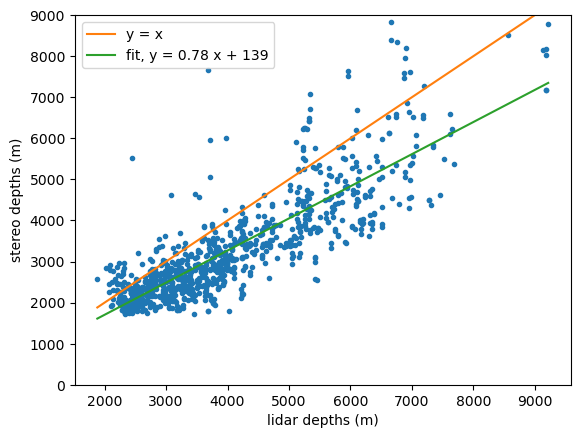

(0.8432669444274232, 7.6246285777136015e-258)


In [16]:
#%%
# #Camera matrices and distortion for the 1280x960 resolution (camera 1 and camera 2)
# CamM_1 = np.array([[5.115201885073643666e+02,0.0,3.069700637546008579e+02],
#                   [0.0,5.110005291739051358e+02,2.441830592759120862e+02],
#                   [0.0,0.0,1.0]])
# CamM_2 = np.array([[5.063166013857816665e+02,0.0,3.166661931952413056e+02],
#                    [1.0,5.067357512519903935e+02,2.526423174030390157e+02],
#                    [0.0,0.0,1.0]])

# Distort_1 = np.array([2.791793909906162274e-01,-7.229131626061370275e-01,3.998341915440934737e-03,2.866146329555672653e-03,6.224929102783540724e-01])
# Distort_2 = np.array([2.326755157584974587e-01,-6.011054678561147391e-01,3.963575587693899294e-04,-2.566491984608918874e-04,4.822591716560123420e-01])
#%%
#camera matrices and distortion for the 640x480 resolution
#i am using the 640x480v2 values for both cameras because camera3 doesn't have its own
CamM_left = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

CamM_right = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])


Distort_left = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
Distort_right = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])

w, h = 640, 480

#Create stereo matching object and set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error.
win_size = 8
min_disp = 0
max_disp = 7
num_disp = 16*max_disp - 16*min_disp # Needs to be divisible by 16

#Create Block matching object.
stereo = cv.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 9,
 uniquenessRatio = 13,
 speckleWindowSize = 5,
 speckleRange = 14,
 disp12MaxDiff = 7,
 P1 = 8*3*win_size**2,
 P2 =32*3*win_size**2) 

# load corresponding lidar points (could improve time matching?)
decimal_time = []
azi = []
elev = []
distance = []
backscatter = []
folder = "C:/Users/kathe/OneDrive/Documents/lidar"
yearmonth = '202110'
yearmonthday = '20211022'
hour = '12'
for time in [1,2,3,4,5]:
        filename = f'{folder}/User5_18_{yearmonthday}_{hour}{time}000.hpl'
        ld = LidarData.fromfile(filename)
        data_locs = ld.data_locs
        decimal_time.append(list(data_locs[:,0]))
        azi.append(list(data_locs[:,1]))
        elev.append(list(data_locs[:,2]))
        distance.append(list(ld.getDistance()))
        backscatter.append(list(ld.getBackscatter()))

decimal_time = np.array(flattenList(decimal_time), ndmin=1)
azi = np.array(flattenList(azi), ndmin=1)
elev = np.array(flattenList(elev), ndmin=1)
distance = np.array(flattenList(distance), ndmin=1)
backscatter = np.array(flattenList(backscatter), ndmin=1)

prefix_right = 'tl'
prefix_left = 'tl4'
vidfolder = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/Videos"
dtime = '2021-10-22'
hour = 12
vidcapR = cv.VideoCapture(f'{vidfolder}/{prefix_right}_{dtime}_{hour:0>2}A.mp4')
vidcapL = cv.VideoCapture(f'{vidfolder}/{prefix_left}_{dtime}_{hour:0>2}A.mp4')

camera_time = hour
stereo_x = []
stereo_y = []
stereo_z = []
stereo_coords = []
stereo_depths = []
lidar_depths = []
time_points = []
disparity = []
while(vidcapR.isOpened() and vidcapL.isOpened()):
    success, imgRLarge = vidcapR.read()
    success2, imgL = vidcapL.read()
    if success==True and success2==True:
        imgR = cv.resize(imgRLarge,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
        imgR = gaussian_contrast(imgR)
        imgL = gaussian_contrast(imgL)

        ### use if you want to mask out the sky as well ###
        
        # rg_ratio1 = imgR[:, :, 1]/imgR[:, :, 2]
        # skymask_C1 =  mask_C1[:,:,0] & (rg_ratio1<1.1) & (rg_ratio1>0.93)  #
        # imgR_skymask = (cv.cvtColor(imgR, cv.COLOR_BGR2GRAY))
        # imgR_skymask = cv.remap(imgR_skymask, mapx, mapy, cv.INTER_LINEAR)
        # imgR_skymask = cv.bitwise_and(imgR_skymask, imgR_skymask, mask=skymask_C1)

        #rg_ratio2 = imgL[:, :, 1]/imgL[:, :, 2]
        #mask_C3 =  mask_C3[:,:,0] & (rg_ratio1<1.1) & (rg_ratio1>0.93)  #
        #imgR_skymask = (cv.cvtColor(imgL, cv.COLOR_BGR2GRAY))
        # imgR_skymask = cv.remap(imgR_skymask, mapx, mapy, cv.INTER_LINEAR)
        # imgR_skymask = cv.bitwise_and(imgR_skymask, imgR_skymask, mask=mask_C3)

#         imgR = cv.bitwise_and(imgR, imgR, mask=mask_C1)
#         imgL = cv.bitwise_and(imgL, imgL, mask=mask_C3)

        #assume both images have same height and width

        new_camera_matrixleft, roi = cv.getOptimalNewCameraMatrix(CamM_left,Distort_left,(w,h),0,(w,h))
        new_camera_matrixright, roi = cv.getOptimalNewCameraMatrix(CamM_right,Distort_right,(w,h),0,(w,h))

        #Undistort images
        imgR_undistorted = cv.undistort(imgR, CamM_right, Distort_right, new_camera_matrixright)
        imgL_undistorted = cv.undistort(imgL, CamM_left, Distort_left, new_camera_matrixleft)

        #creates new map for each camera with the rotation and pose (R and P) values
#         mapLx, mapLy = cv.initUndistortRectifyMap(new_camera_matrixleft, Distort_left, Rleft, Pleft, (w,h), cv.CV_32FC1)
#         mapRx, mapRy = cv.initUndistortRectifyMap(new_camera_matrixright, Distort_right, Rright, Pright, (w,h), cv.CV_32FC1)
        mapLx, mapLy = cv.initUndistortRectifyMap(new_camera_matrixleft, Distort_left, stereo_cal.get('Rleft'), stereo_cal.get('Pleft'), (w,h), cv.CV_32FC1)
        mapRx, mapRy = cv.initUndistortRectifyMap(new_camera_matrixright, Distort_right, stereo_cal.get('Rright'), stereo_cal.get('Pright'), (w,h), cv.CV_32FC1)
        
        
        # remaps each image to the new map
        rimgR = cv.remap(imgR_undistorted, mapRx, mapRy,
                              interpolation=cv.INTER_NEAREST,
                              borderMode=cv.BORDER_CONSTANT,
                              borderValue=(0, 0, 0, 0))
        rimgL = cv.remap(imgL_undistorted, mapLx, mapLy,
                              interpolation=cv.INTER_NEAREST,
                              borderMode=cv.BORDER_CONSTANT,
                              borderValue=(0, 0, 0, 0))

        # compute disparity map for the rectified images
        disparity_map = stereo.compute(rimgL, rimgR).astype(np.float32) #- 16*11.365853658536585

        disp_masked = cv.bitwise_and(disparity_map, disparity_map, mask=mask_C1)
        
        im3d = cv.reprojectImageTo3D(disparity_map/16, stereo_cal.get('Q'), handleMissingValues = True)
#         im3d = cv.reprojectImageTo3D((disparity_map)/16, Q_new, handleMissingValues = True)
        
        # remove areas where matching failed
        im3d[im3d == np.inf] = 0
        im3d[im3d > 9_000] = 0
        im3d[im3d < -9_000] = 0
        im3d[im3d == -np.inf] = 0

        zdepths = im3d[:,:,2]
        depths = np.sqrt( im3d[:,:,0]**2 + im3d[:,:,1]**2 + im3d[:,:,2]**2)

        rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 2]
        skymask_C1 =  mask_C1[:,:,0] & (rg_ratio1<1.1) & (rg_ratio1>0.93)  #
        depths_skymask = cv.bitwise_and(depths, depths, mask=skymask_C1)

        camera_time += 5/3600
        for time in decimal_time:
            if np.abs(time-camera_time) < 0.001:
                i = list(decimal_time).index(time)
                cloudindex, cloud = findCloud(backscatter[i], 500)  
                point = np.array((azi[i], elev[i]))
                new = lidarToRectifiedSingle(point, lidarH, cameraH)
                if cloud is not None:
                    if int(new[0]) < 640 and int(new[1]) < 480:
                        if depths[int(new[1]), int(new[0])] > 1000:
                            if im3d[:,:,2][int(new[1]), int(new[0])] > 0:
                                if im3d[:,:,0][int(new[1]), int(new[0])] > 0:
                                    stereo_depths.append(depths[int(new[1]), int(new[0])])
                                    stereo_x.append(im3d[:,:,0][int(new[1]), int(new[0])])
                                    stereo_y.append(im3d[:,:,1][int(new[1]), int(new[0])])
                                    stereo_z.append(im3d[:,:,2][int(new[1]), int(new[0])])
                                    stereo_coords.append(np.array([new[0], new[1]]))
                                    time_points.append(camera_time) #currently in decimal time
                                    lidar_depths.append(cloud)
                else:
                    pass

        if cv.waitKey(1) & 0xFF == ord('q'):
            break 
    else:
        break

    
# When everything done, release the video capture object
vidcapL.release()
vidcapR.release()

# Closes all the frames
cv.destroyAllWindows()

# plot lidar and stereo depths
plt.plot(lidar_depths, stereo_depths,'.')
plt.xlabel('lidar depths (m)')
plt.ylabel('stereo depths (m)')
plt.ylim(0, 9000)
coefs = np.polynomial.polynomial.polyfit(lidar_depths, stereo_depths, 1)

ffit = np.poly1d(coefs[::-1])
x_new = np.linspace(min(lidar_depths), max(lidar_depths))
plt.plot(x_new, x_new, label='y = x')
plt.plot(x_new, ffit(x_new), label= f'fit, y = %.2f x + {int(coefs[0])}' % coefs[1])
plt.legend()
plt.savefig(f'{yearmonthday}_{hour}_scatterManualRectify.png', bbox_inches='tight')
plt.show()

from scipy.stats import pearsonr
print(pearsonr(lidar_depths, stereo_depths))


### reject points from the fit that look like anomalies

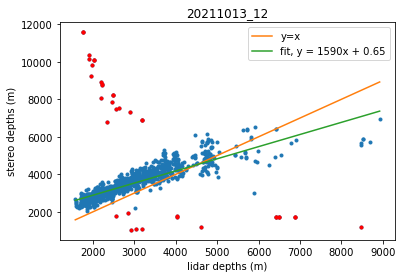

(0.5527043047339703, 1.1904031895997218e-102)
(0.8275360077896703, 3.495733012e-314)


In [10]:
# stereo_short = stereo_depths[::4]
# lidar_short = lidar_depths[::4]

fig, ax = plt.subplots(1,1)
ax.plot(lidar_depths, stereo_depths,'.')


#find the points which have stereo distance underestimated/overestimated
anomalies = []
anomaly_times = []
anomalous_stereo = []
anomalous_lidar = []
for i in range (0, len(lidar_depths)):
    if stereo_depths[i] > lidar_depths[i] + 2800:
        anomalies.append(stereo_coords[i])
        anomaly_times.append(time_points[i])
        anomalous_stereo.append(stereo_depths[i])
        anomalous_lidar.append(lidar_depths[i])
        ax.plot(lidar_depths[i], stereo_depths[i], 'r.')
    if stereo_depths[i] < 2000:
        anomalies.append(stereo_coords[i])
        anomaly_times.append(time_points[i])
        anomalous_stereo.append(stereo_depths[i])
        anomalous_lidar.append(lidar_depths[i])
        ax.plot(lidar_depths[i], stereo_depths[i], 'r.')
anomalies = np.array(anomalies)

good_stereo = []
good_lidar = []
for i in range (0, len(lidar_depths)):
    if stereo_depths[i] < lidar_depths[i] + 2800 and stereo_depths[i] > 1500:
        good_stereo.append(stereo_depths[i])
        good_lidar.append(lidar_depths[i])
good_stereo = np.array(good_stereo)
good_lidar = np.array(good_lidar)


ax.set_xlabel('lidar depths (m)')
ax.set_ylabel('stereo depths (m)')
#plt.ylim(0, 9000)
coefs = np.polynomial.polynomial.polyfit(good_lidar, good_stereo, 1)

ffit = np.poly1d(coefs[::-1])
x_new = np.linspace(min(lidar_depths), max(lidar_depths))
#ax.plot(good_lidar, good_stereo, 'g.')
ax.plot(x_new, x_new, label='y=x')
ax.plot(x_new, ffit(x_new), label=f'fit, y = {int(coefs[0])}x + %.2f' % coefs[1])
ax.set_title(f'{yearmonthday}_{hour}')
ax.legend()
#plt.savefig(f'{yearmonthday}_{hour}_scatter_NoAnomaliesJustBuildingmask.png', bbox_inches='tight')
plt.show()

from scipy.stats import pearsonr
print(pearsonr(lidar_depths, stereo_depths))
print(pearsonr(good_lidar, good_stereo))

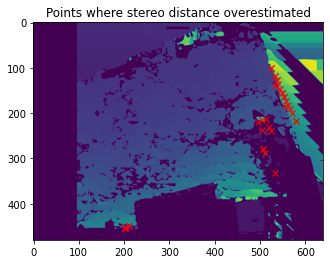

In [46]:
fig, ax = plt.subplots(1,1)
ax.imshow(depths)
ax.plot(anomalies[:,0], anomalies[:,1], 'rx')
ax.set_title('Points where stereo distance overestimated')
#plt.savefig('stereoAnomaliesJustBuildingMask_20211013_12.png', bbox_inches='tight')